In [1]:
import pytorch_lightning as pl
import pytorch_lightning.callbacks as pl_callbacks
import torch
import numpy as np
import pandas as pd

import eq

In [2]:
torch.cuda.is_available()

True

## Loading the catalog

In [3]:
print(eq.data.default_catalogs_dir)

/home/gcl/RB/kdascher/Projects/DS_Discovery/recast/data


In [4]:
catalog = eq.catalogs.ANSS_MultiCatalog(    
    num_sequences=10000,
    t_end_days=4*365,
    mag_completeness=4.5,
    minimum_mainshock_mag=6.0,
)

Loading existing catalog from /home/gcl/RB/kdascher/Projects/DS_Discovery/recast/data/ANSS_MultiCatalog.


/home/gcl/RB/kdascher/Projects/DS_Discovery/recast/eq/data/sequence.py:207: UserWarning: Found 1 zero inter-event times in the sequence. This violates fundamental assumptions of TPP models and may lead to incorrect log-likelihood values.
  warnings.warn(


### Train / val / test split

To compare different models, by default we split the full dataset of event sequences into 3 components:
- `train`: sequences used for training the models, includes events between `1990-01-01` and `2010-01-01`.
- `val`: used for early stopping and hyperparameter selection, includes events between `2010-01-01` and `2015-01-01`.
- `test`: used for final evaluation, includes events between `2015-01-01` and `2020-01-01`.

So now the train, val and test sequences are stored in `catalog.train`, `catalog.val` and `catalog.test`, respectively.

Note that there are multiple event sequences stored in `catalog.train`, `catalog.val` and `catalog.test`.

In [5]:
print("Train sequence:")
print(catalog.train[0])
print("\nValidation sequence:")
print(catalog.val[0])
print("\nTest sequence:")
print(catalog.test[0])

Train sequence:
Sequence(
  inter_times: [2261],
  arrival_times: [2260],
  t_start: 0.0,
  t_end: 1460.0,
  t_nll_start: 0.0,
  mag: [2260]
)

Validation sequence:
Sequence(
  inter_times: [791],
  arrival_times: [790],
  t_start: 0.0,
  t_end: 1460.0,
  t_nll_start: 0.0,
  mag: [790]
)

Test sequence:
Sequence(
  inter_times: [438],
  arrival_times: [437],
  t_start: 0.0,
  t_end: 1460.0,
  t_nll_start: 0.0,
  mag: [437]
)


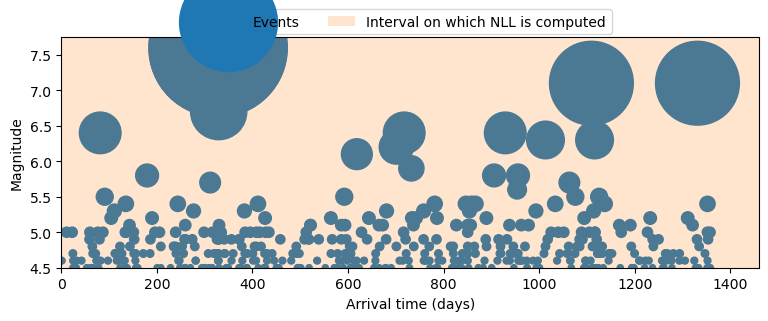

In [6]:
eq.visualization.visualize_sequence(catalog.test[0], show_nll=True);

## Training the model

We will train the model using the high-level API provided by `pytorch_lightning`.

For this, we first need to create `torch.utils.data.DataLoader` objects that will feed the data into the model.

In [16]:
dl_train = catalog.train.get_dataloader(batch_size=min(500,len(catalog.train)), shuffle=True)
dl_val = catalog.val.get_dataloader(batch_size=min(500,len(catalog.val)))
dl_test = catalog.test.get_dataloader(batch_size=min(500,len(catalog.test)))

In [8]:
T = catalog.train[0].t_end
N = np.mean([len(seq) for seq in catalog.train])
mag_mean = np.mean([catalog.train[0].mag.mean().item() for seq in catalog.train])
tau_mean = T/N

model = eq.models.RecurrentTPP(
    mag_mean = mag_mean,
    tau_mean = tau_mean,
    mag_completeness=catalog.metadata['mag_completeness'],
    learning_rate=1e-3,
)

`pytorch_lightning.Trainer` takes care of training the model, early stopping and saving the best weights.

In [9]:
# ModelCheckpoints saves the model with the best validation loss
checkpoint = pl_callbacks.ModelCheckpoint(monitor="total_val_loss")

# EarlyStopping stops training if the validation loss doesn't improve by more than 1e-3 for 20 epochs
early_stopping = pl_callbacks.EarlyStopping(monitor="total_val_loss", patience=10, min_delta=1e-5)

# RichProgressBar adds a nice and more functional progress bar
progress_bar = pl_callbacks.RichProgressBar()

# Trainer set up training and validation loops with previous specs
trainer = pl.Trainer(devices=1,max_epochs=1000, callbacks=[checkpoint, early_stopping, progress_bar],log_every_n_steps=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/gcl/RB/kdascher/yes/envs/DS-discovery/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(


In [10]:
trainer.fit(model, dl_train, dl_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type    ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩
│ 0 │ hypernet_time │ Linear  │  3.2 K │
│ 1 │ hypernet_mag  │ Linear  │     33 │
│ 2 │ rnn           │ GRU     │  3.5 K │
│ 3 │ dropout       │ Dropout │      0 │
└───┴───────────────┴─────────┴────────┘

Trainable params: 6.7 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 6.7 K                                                                                                
Total estimated model params size (MB): 0

Output()

/home/gcl/RB/kdascher/yes/envs/DS-discovery/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_
connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on 
this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

/home/gcl/RB/kdascher/yes/envs/DS-discovery/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_
connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on 
this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

`Trainer.fit` stopped: `max_epochs=5` reached.


## Evaluation

<Axes: xlabel='epoch', ylabel='val_loss'>

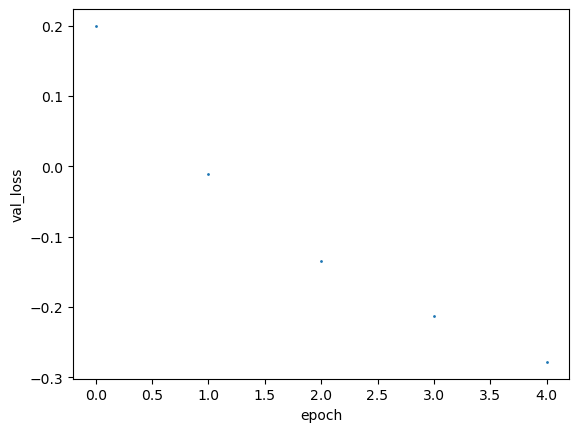

In [17]:
metrics = pd.read_csv('/home/gcl/RB/kdascher/Projects/DS_Discovery/recast/notebooks/lightning_logs/version_11/metrics.csv')
metrics.plot.scatter(x='epoch',y='val_loss',s=1)

Load the model with the best validation loss

In [12]:
checkpoint.best_model_path

'/home/gcl/RB/kdascher/Projects/DS_Discovery/recast/notebooks/lightning_logs/version_11/checkpoints/epoch=4-step=60.ckpt'

In [13]:
model.load_from_checkpoint(checkpoint.best_model_path)

RecurrentTPP(
  (hypernet_time): Linear(in_features=32, out_features=96, bias=True)
  (hypernet_mag): Linear(in_features=32, out_features=1, bias=True)
  (rnn): GRU(2, 32, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

After training the model, we compute the loss on the negative log-likelihood (NLL) loss on the test set.

In [14]:
trainer.test(model, dl_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Output()

/home/gcl/RB/kdascher/yes/envs/DS-discovery/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.4719354808330536     │
│      total_test_loss      │    0.4719354808330536     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4719354808330536, 'total_test_loss': 0.4719354808330536}]

In [ ]:
trainer.test(model, dl_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -0.5846961140632629
     total_test_loss        -0.5846961140632629
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': -0.5846961140632629, 'total_test_loss': -0.5846961140632629}]